## TME 7 : chaîne de Markov cachée
### Annotation de gènes par chaînes de Markov cachées

Les modèles de chaînes de Markov cachées sont très utilisés notamment dans les domaines de la reconnaisance de la parole, du traitement automatique du langage naturel, de la reconnaissance de l'écriture manuscrite et de la bioinformatique.

Les trois problèmes de base des HMM (*Hidden Markov Model*) sont :
1. Évaluation : 
 -  Problème : calculer la probabilité d’observation de la séquence d’observations étant donné un HMM:  
 -  Solution : *Forward Algorithm *  


2. Décodage : 
 - Problème : trouver la séquence d’états qui maximise la vraisemblance de la séquence d’observations 
 - Solution : *Viterbi Algorithm *  


3. Entraînement :  
 - Problème : ajuster les paramètres du modèle HMM afin de maximiser la probabilité de générer une séquence d’observations à partir de données d’entraînement  
  - Solution : *Forward-Backward Algorithm*
  

Dans ce TME, nous allons appliquer l'algorithme Viterbi à des données biologiques.

# Rappel de biologie

Dans ce TME nous allons voir comment les modèles statistiques peuvent être utilisés pour extraire de l'information des données biologiques brutes. Le but sera de spécifier des modèles de Markov cachées qui permettent d'annoter les positions des gènes dans le génome.

Le génome, support de l'information génétique, peut être vu comme une longue séquence de caractères écrite dans un alphabet à 4 lettres: A , C , G et T . Chaque lettre du génome est aussi appelée pair de base (ou bp). Il est maintenant relativement peu coûteux de séquencer un génome (quelques milliers d'euros pour un génome humain). Cependant on ne peut pas comprendre, simplement à partir de la suite de lettres, comment cette information est utilisée par la cellule (un peu comme avoir à disposition un manuel d'instructions écrit dans une langue inconnue).

Un élément essentiel est le gène, qui après transcription et traduction produira les protéines, les molécules responsables de la grande partie de l'activité biochimique des cellules.

La traduction en protéine est faite à l'aide du code génétique qui, à chaque groupe de 3 lettres (ou bp) transcrites fait correspondre un acide aminé. Ces groupes de 3 lettres sont appelés codon et il y en a 4^3, soit 64. Donc, en première approximation, un gène est défini par les propriétés suivantes (pour les organismes procaryotes):

- Le premier codon, appelé codon start est ATG,
- Il y a 61 codons qui codent pour la séquence d'acides aminés.
- Le dernier codon, appelé codon stop, marque la fin du gène et est l'une des trois séquences TAA , TAG ou TGA . Il n'apparaît pas dans le gène. 


Nous allons intégrer ces différents éléments d'information pour prédire les positions des gènes. Notez que pour simplifier nous avons omis le fait que la molécule d'ADN est constituée de deux brins complémentaires, et donc que les gènes présents sur le brin complémentaire sont vus "à l'envers" sur notre séquence. Les régions entre les gènes sont appelées les régions intergéniques . 

![Image of Yaktocat](https://cdn.kastatic.org/ka-perseus-images/1ade7bbd40ca8dbc7a55ddf4067935e42c347f35.png)

Chacune des séquences de gènes commence par un codon start et fini par un des codons stop. 

# Modélisation de gènes 
## Question 1 : Téléchargement des données

Nous travaillerons sur le premier million de bp du génome de E. coli (souche 042). Plutôt que de travailler avec les lettres A , C , G et T , nous allons les recoder avec des numéros (A =0, …, T =3). Les annontations fournies sont :
- 0 si la position est dans une region non codante = region intergenique
- 1 si la position correspond a la position 0 d'un codon
- 2 si la position correspond a la position 1 d'un codon
- 3 si la position correspond a la position 2 d'un codon

In [7]:
# téléchargez le fichier et ouvrez-le avec pickle
import numpy as np
import pickle as pkl

Genome = np.load('genome.npy') # le premier million de paires de bases de E. coli
Annotation = np.load('annotation.npy') # L'annotation sur le génome

# On divise nos données, la moitié sert à l'apprentissage du modèle,
#l'autre partie à son évaluation

genome_train=Genome[:500000]
genome_test=Genome[500000:]

annotation_train=Annotation[:500000]
annotation_test=Annotation[500000:]

# remarque : cette fois, les données d'apprentissage 
# ne sont plus des séries séparées d'observations cohérentes
# mais bien des observations ponctuelles, isolées et étiquetées
# alors, l'approche change un tout petit peu par rapport à la semaine passée

## Question 2 : Apprentissage 

Comme modèle le plus simple pour séparer les séquences de codons des séquences intergéniques, on va définir la chaîne de Markov caché dont le graphe de transition est donné ci dessous. 

![Image of Yaktocat](http://mapsi.lip6.fr/uploads/Cours/modele1.png)

Un tel modèle se définit de la manière suivante : on considère qu'il existe 4 états cachés possibles (intergénique, codon 0, codon 1, codon 2).

On peut rester dans les régions intergéniques, et au démarrage du gène, la composition de chaque base du codon est différente. Il va falloir, afin de pouvoir utiliser ce modèle pour classifier, connaître les paramètres de la matrice de transition (donc ici uniquement les probas $a$ et $b$), et les lois $(b_i,i=0,…,3)$ des observations pour les quatre états.

```python
Pi = np.array([1, 0, 0, 0])  ##on commence dans l'intergenique
A =  np.array([[1-a, a  , 0, 0], 
              [0  , 0  , 1, 0],
              [0  , 0  , 0, 1],
              [b  , 1-b, 0, 0 ]])
B = ...

```


Etant donné la structure d'un HMM (Hidden Markov Chain):

- les observations n'influencent pas les états: les matrices $\Pi$ (distribution de probabilité initiale), $A$ (matrice de transition) s'obtiennent comme dans un modèle de Markov simple (cf semaine 6)
- chaque observation ne dépend que de l'état courant 

La nature des données nous pousse à considérer des lois de probabilités discrètes quelconques pour les émissions. L'idée est donc de procéder par comptage en définissant la matrice $B$ (matrice de probabilités des émissions) comme suit:

- $K$ colonnes (nombre d'observations), $N$ lignes (nombre d'états)
- Chaque ligne correspond à une loi d'émission pour un état (ie, chaque ligne somme à 1) 

Ce qui donne l'algorithme:

1. $b_{ij}$ = comptage des émissions depuis l'état $s_i$ vers l'observation $x_j$
2. normalisation des lignes de $B$ 

Donner le code de la fonction `def learnHMM(allX, allS, N, K):` qui apprend un modèle à partir d'un ensemble de couples (seq. d'observations, seq. d'états) 

In [8]:
def learnHMM(allx, allq, N, K):
    """ apprend un modèle à partir 
    d'un ensemble de couples (seq. d'observations, seq. d'états) 
    retourne les matrices A  B """
    A = np.zeros((N, N)) 
    B = np.zeros((N, K)) # nouvelle venue : la matrice d'émission.
    # Pi est connue, plus besoin
    for x in range(len(allx)-1):
        seenow=allx[x] # see est une observation ponctuelle au coeur de mon ensemble d'observations.
        knownow=allq[x] # normalement, elle est étiquetée avec un état de même indice.
        knowthen = allq[x+1] # on s'intéresse aussi à l'état associé à sa voisine
        A[knownow][knowthen]+=1 # incrémenter l'effectif des passages de l'état courant au suivant dans la matrice de transition.
        B[knownow][seenow]+=1 # incrémenter l'effectif des liens entre l'état courant et l'observation dans la matrice d'émission.
    # normalisation - l'objectif étant bien sûr d'obtenir des probabilités.
    A/=np.maximum(A.sum(1).reshape(N,1),1) 
    B/=np.maximum(B.sum(1).reshape(N,1),1)
    # et voilà
    return A, B

In [9]:
Pi = np.array([1, 0, 0, 0])
nb_etat = 4 ## (intergénique, codon 0, codon 1, codon 2)
nb_observation = 4 ## (A,T,C,G)
A,B = learnHMM(genome_train, annotation_train, nb_etat, nb_observation)
print(A)
print(B)
# affichage de référence : code validé

[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
[[0.24347301 0.25247284 0.2480025  0.25605165]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]


Vous devez trouver 

$A= $
```python
[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]```
$B=$       
```python
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]```
        
Notez que ce sont des matrices de probabilites, la somme de chaque ligne donne 1.

## Question 3 :  Estimation la séquence d'états par Viterbi

Il n'est pas toujours évident de trouver les régions codante et non codante d'un genome. Nous souhaiterions annonter automatiquement le genome, c'est à dire retrouver **la sequence d'état caché la plus probable** ayant permis de générer la séquence d'observation.

Rappels sur l'algorithme Viterbi (1967):

- Il sert à estimer la séquence d'états la plus probable étant donnés les observations et le modèle.
- Il peut servir à approximer la probabilité de la séquence d'observation étant donné le modèle. 

1\. Initialisation (avec les indices à 0 en python): 

$$\begin{array}{ccccccccc} \delta_{0} (i) &=& \log \pi_{i} +\log b_{i} (x_{1}) \\ \Psi_{0}(i) &=& -1 \mbox{ Note: -1 car non utilisé normalement} \end{array}$$

2\. Récursion: 

$$ \begin{array}{ccccccccc} \delta_{t} (j) &=&\displaystyle \left[\max_{i} \delta_{t-1}(i) + \log a_{ij}\right] + \log b_{j}(x_{t}) \\ \Psi_{t}(j) &=&\displaystyle \arg\max_{i\in [1,\ N]} \delta_{t-1} (i) + \log a_{ij} \end{array}$$

3\. Terminaison (indices à {$T-1$} en python) 

$$ S^{\star} = \max_{i} \delta_{T-1}(i)$$

4\. Chemin $$\begin{array}{ccccccccc} s_{T-1}^{\star} & = &\displaystyle \arg\max_{i} \delta_{T-1}(i) \\ s_{t}^{\star} & = & \displaystyle \Psi_{t+1}(s_{t+1}^{\star}) \end{array}$$

L'estimation de $\log p(x_0^{T-1} | \lambda)$ est obtenue en cherchant la plus grande probabilité dans la dernière colonne de $\delta$. Donner le code de la méthode `viterbi(x,Pi,A,B):` 


In [10]:
def viterbi(allx,Pi,A,B):    
    
    ## initialisation
    chemin = np.zeros(len(allx))
    # servira à stocker les états prédits (une liste de psi), il y en a autant que d'observations
    psi = np.zeros((len(A), len(allx))) # A = N, len(allx) = T
    psi[:,0]= -1
    delta = np.zeros((len(A), len(allx)))
    delta[:,0] = np.log(Pi) + np.log(B[:,allx[0]]) 
    # delta est une probabilité jointe sous la forme log, donc une somme
    # au rang 0:
    # B[i,allx[0]] est la probabilité que l'état i ait émis la première observation...
    # ...pondérée par Pi[i], la probabilité d'être effectivement dans l'état i au départ
    
    temp = np.zeros(len(A))
    
    ## récursion : on cherche psi[j,t]
    for t in range(1,len(allx)) : # sur tous les temps d'observation t :
        olddelta = delta[:,t-1]  # se référer au delta précédent
        for j in range(len(A)): # sur tous les états j :
            temp = olddelta + np.log(A[:,j])
            delta[j,t] = np.amax(temp) + np.log(B[j,allx[t]]) 
            # chercher le maximum des probabilités d'être arrivé jusqu'ici
            # (ne dépend que de l'état d'avant selon l'hypothèse MC)
            # le multiplier par la probabilité d'émission de ce que je vois si j'ai raison sur l'état (c'est une somme en log-p)
            psi[j,t] = np.argmax(temp)
            # psi[j,t] va donc être l'état précédent qui a justement le plus de chances d'avoir généré celui-ci
            
    ## terminaison
    certitude = np.amax(delta[:,len(allx)-1])
    # probabilité d'avoir effectivement emprunté ce chemin pour arriver ici,
    # "ici" étant ce que je vais calculer ci-dessous : la dernière étape du chemin ↓
    chemin[len(allx)-1] = np.argmax(delta[:,len(allx)-1])
    # voilà, j'ai donc récupéré l'état final prédit.
    # pour reconstituer tout le chemin, je dois faire les opérations dans l'autre sens.
    for t in range(len(allx)-2,0,-1):
        chemin[t] = psi[int(chemin[t+1]),t+1]
    # la séquence est passée par les états de [chemin] ; j'en suis assuré.e à certitude%.
    return chemin, certitude       

In [11]:
etats_predits=viterbi(genome_test,Pi,A,B)[0]
print(etats_predits)

C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


[0. 0. 0. ... 1. 2. 3.]


## Affichage
On met les états cachés à 0, pour les séquences non codantes, et à 1 pour les gènes

```python
etat_predits[etat_predits!=0]=1 
annotation_test[annotation_test!=0]=1
```
puis on affiche pour chaque position du génome si elle est codante ou non, en utilisant les vraies annotations, puis en utilisant les prédictions.
```python
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction", ls="--")
plt.legend(loc="best")
plt.show()
```

Vous pouvez considérer une sous partie du génome, par exemple entre 100000 et 200000. Commentez vos observations sur la qualité de la prédiction.

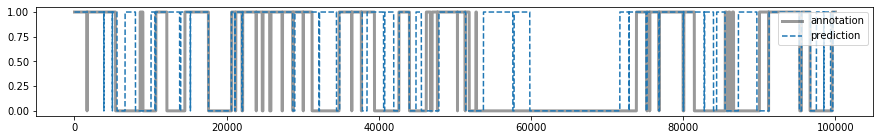

In [12]:
import matplotlib.pyplot as plt

etats_predits[etats_predits!=0]=1 
annotation_test[annotation_test!=0]=1
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test[100000:200000], label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etats_predits[100000:200000], label="prediction", ls="--")
plt.legend(loc="best")
plt.show()

Le bleu et le gris ne concordent pas. Bien des régions jugées codantes (mises à 1) par le classifieur ne le sont en fait pas si l'on suit les annotations par défaut (le bleu est seul à l'étage du dessus).  
Par contre, presque toutes les régions jugées codantes sont reconnues comme telles (le gris est rarement seul à l'étage du dessus).

## Question 4 :  Evaluation des performances

A partir des predictions et des vrai annotations du genome, dessiner la matrice de confusion. 

<img src="confusion.png" width="200">

Avec : 
- TP = True Positives, les régions codantes correctement prédictes,
- FP = False Positives, les régions intergénique prédites comme des régions codantes,
- TN = True Negatives, les régions intergeniques prédites correctement,
- FN = False Negatives, les régions codantes prédites comme non codantes.

L'état non codant est l'état 0, les autres (1,2,3) sont les états codants.

![](conf2.png)


In [13]:
def create_confusion_matrix(true_sequence, predicted_sequence):
    confusion = np.zeros((2,2)) # car deux états possibles, codant ou intergénique
    for i in range(len(true_sequence)):
        confusion[int(1-predicted_sequence[i]),int(1-true_sequence[i])] += 1
        # sans la soustraction, la case 1,1 correspondrait à (codant, codant),
        # or on demande qu'elle corresponde à (inter, inter)
    return confusion

Apres avoir créé la matrice de confusion, vous pouvez l'afficher en utilisant :

```python

mat_conf=create_confusion_matrix(annotation_test, etat_predits)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

print(mat_conf)
plt.show()
```

(2, 2)
[[202819. 152699.]
 [ 31460. 113022.]]


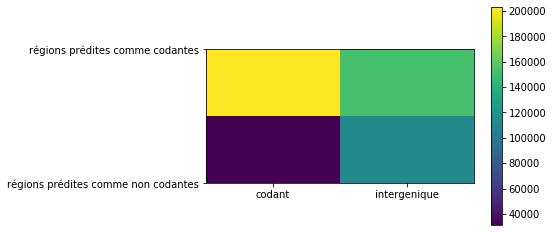

In [14]:
import matplotlib.pyplot as plt 

mat_conf=create_confusion_matrix(annotation_test,etats_predits)
print(mat_conf.shape)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['régions prédites comme codantes','régions prédites comme non codantes']);

print(mat_conf)
plt.show()

Donner une interprétation.
Peut on utiliser ce modèle pour prédire la position des gènes dans le génome ?

Il semblerait que notre classifieur ne rate presque jamais une région codante (le jaune est très vif, tous les effectifs sont donc concentrés sur la bonne case). Cette certitude relative sur les True Positives (on parle de "rappel" élevé) devrait être informative.    
Elle ne l'est pas.  
La confusion est trop grande de l'autre côté de la matrice ("précision" trop faible). Cette propension du classifieur à juger une majorité de régions comme codantes sème le doute sur toutes les prédictions, y compris celles qui sont justes. La matrice représente une probabilité conditionnelle, et on compte justement sur lui pour savoir dans quel monde l'on est ; ici, il est presque aussi incertain que nous (57/43 ~ 50/50). En d'autres termes, la loi jointe serait très loin des valeurs attendues.

In [37]:
TP,FP = mat_conf[0] 
FN,TN = mat_conf[1] 
rappel = TP/(TP+FN)*100
# est-ce que je rate des régions codantes ?
print(rappel)
# non. je suis donc rassuré.e

# ***je ne devrais pas***

precision = TP/(TP+FP)*100
# est-ce que je m'alarme souvent pour rien ?
print(100-precision)
# oui. 43% des régions jugées codantes sont de fausses alertes.

# Le classifieur est donc quand même loin d'être digne de confiance.

86.57156638025602
42.951130463155174


## Question 5 :  Génération de nouvelles séquences

En utilisant le modèle $ \lambda=\{Pi,A,B\}$ créer ` create_seq(N,Pi,A,B) ` une fonction permétant de générer
- une séquence d'état cachés
- une sequence d'observation.

In [10]:
import random

def tirageDiscret(Pi):
    # somme cumulée
    sc = np.cumsum(Pi)
    # tirage entre 0 et 1
    t = random.random()
    # recherche de dépassement
    for i in range(len(sc)):
        if sc[i] > t:
            return i
    # et s'il n'y a pas de dépassement,
    # il faut bien retourner quelque chose
    return len(sc)-1

def create_seq(N,Pi,A,B):
    '''
    Produire N états cachés en utilisant Pi et A    
    et pour chaque état caché produire une observation en utilisant B
    '''
    etats = []
    obs = []
    # tirer un état selon les probabilités initiales
    etats.append(tirageDiscret(Pi))
    for i in range(N-1):
        etat = etats[i]
        # tirer un successeur selon la loi de probabilité associée à l'état courant
        etats.append(tirageDiscret(A[etat]))
        obs.append(tirageDiscret(B[etat]))
    return etats, obs

In [11]:
create_seq(5000000,Pi,A,B)
# Selon Pi, on commence nécessairement dans l'état 0 (non codant):
# or, la matrice A obtenue et validée au tout début donne une chance presque totale de rester dans l'état 0.
# Il est donc attendu que TOUS les états successifs soient de type 0 sur de petits tirages.
# Il faudra avoir eu la chance de quitter une fois l'état 0 pour commencer à générer des choses intéressantes.

# Côté états, les choses intéressantes en question sont toutes des mots de la forme {1,2,3}*, 
# puisque les paires de bases vont par trois pour former un codon,
# que les états de la partie codante sont définis comme 1="être la première", 2="la seconde" ou 3="la troisième base d'un codon",
# et qu'un gène n'est qu'une suite plus ou moins longue de ces codons.

# Côté observations, l'oeil humain ne peut absolument pas faire la différence entre ce qui est censé être codant
# et ce qui ne l'est pas. Seule la machine se rend compte que la distribution des bases est légèrement différente.

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,
  1,
  2,
  3,


## Question 6 : Construction d'un nouveau modèle

Evaluons maintenant si cela s'améliore en prenant en compte les frontières des gènes en construisant un modèle avec codon start et codon stop.
On veut maintenant intégrer l'information complémentaire qui dit qu'un gène commence "toujours" par un codon start et finit "toujours" par un codon stop avec le graphe de transition ci dessous.

On considère donc maintenant un modèle avec 12 états cachés.
![](modele2.png)


- Ecrivez la matrice de transition correspondante, en mettant les probabilités de transition entre lettres pour les codons stop à 0.5.


- Adaptez la matrice des émissions pour tous les états du modèle. Vous pouvez reutiliser la matrice B, calculée précédement. Les états correspondant au codons stop n'émettrons qu'une seule lettre avec une probabilité 1.
Pour le codon start, on sait que les proportions sont les suivantes: ATG : 83% GTG: 14%, et TTG: 3%

```python
Pi2 = np.array(   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ])  ##on commence encore dans l'intergenique
A2 =  np.array([[1-a, a, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                [0  , 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
                  ... ])
B2 = ...

```


In [15]:
Pi2 = np.array([1,0,0,0,0,0,0,0,0,0,0,0])         ## on commence encore dans l'intergénique
a = 0.00100984
b = 0.00272284
# récupération sur les calculs précédents :
# a est la probabilité de sortir de la zone intergénique
# b est la probabilité de retourner à la zone intergénique 

A2 = np.array([ [1-a, a,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0    ],       # si j'en sors, je vais entrer dans un codon start avec une probabilité a
                [0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0    ],       # donc je vais certainement passer à la deuxième base du start
                [0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0    ],       # donc je vais certainement passer à la troisième base du start
                [0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0    ],       # donc je vais certainement commencer à coder
                [0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0    ],       # donc je vais certainement passer à une deuxième base
                [0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0    ],       # donc je vais certainement passer à une troisième base
                [0,   0,   0,   0,   1-b, 0,   0,   b,   0,   0,   0,   0    ],       # et là j'ai le choix, soit finir de coder, soit recommencer
                [0,   0,   0,   0,   0,   0,   0,   0,   0.5, 0.5, 0,   0    ],       # si je finis, je suis arrivé au T stop. la suite sera "G intermédiaire" ou "A intermédiaire", or on a décidé de séparer ces états
                [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1    ],       # si je suis passé par G au milieu, la suite est certainement "A final"
                [0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0.5, 0.5  ],       # si je suis passé par A au milieu, la suite sera "G final" ou "A final"
                [1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0    ],       # fin de gène par G. je vais certainement reprendre l'intergénique
                [1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0    ]])      # fin de gène par A. idem.
                
#l'ordre des états est A C G T selon l'énoncé
B2 = np.array([[0.24347301, 0.25247284, 0.2480025, 0.25605165],  # successions dans l'intergénique : déjà calculé
               [0.83000000, 0.00000000, 0.1400000, 0.03000000],  # chances de commencer le codon start avec A, T ou G, jamais C
               [0.00000000, 0.00000000, 0.0000000, 1.00000000],  # le codon start continue forcément avec T
               [0.00000000, 0.00000000, 1.0000000, 0.00000000],  # le codon start continue forcément avec G
               [0.24727716, 0.23681872, 0.34909315, 0.16681097], # successions dans l'intragénique : déjà calculé
               [0.28462222, 0.23058695, 0.20782446, 0.27696637], # successions dans l'intragénique : déjà calculé
               [0.18579110, 0.26246354, 0.29707437, 0.25467098], # successions dans l'intragénique : déjà calculé
               [0.00000000, 0.00000000, 0.0000000, 1.00000000],  # un codon stop commence forcément avec T
               [0.00000000, 0.00000000, 1.0000000, 0.00000000],  # ce codon stop continue forcément par G si c'est l'état correspondant
               [1.00000000, 0.00000000, 0.0000000, 0.00000000],  # ce codon stop continue forcément par A si c'est l'état correspondant
               [0.00000000, 0.00000000, 1.0000000, 0.00000000],  # sortie du codon stop assurée par G si c'est l'état correspondant
               [1.00000000, 0.00000000, 0.0000000, 0.00000000]]) # sortie du codon stop assurée par A si c'est l'état correspondant

etats_predits2=viterbi(genome_test,Pi2,A2,B2)[0]
etats_predits2[etats_predits2!=0]=1 

C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
C:\Users\msalais\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


Evaluez les performances du nouveau modèle en faisant de nouvelles prédictions d'annotation pour genome_test, et comparez-les avec le modèle précédent. 
```
etat_predits2=viterbi(genome_test,Pi2,A2,B2)
etat_predits2[etat_predits2!=0]=1 
```

```python

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test, label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits, label="prediction model1", ls="--")
ax.plot(etat_predits2, label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()
```

<Figure size 432x288 with 0 Axes>

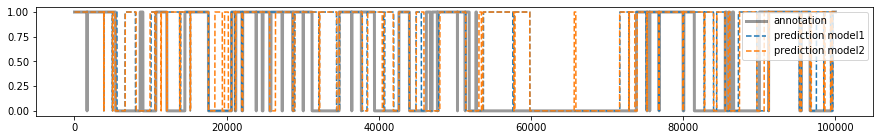

In [17]:
import matplotlib.pyplot as plt 

plt.figure()
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test[100000:200000], label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etats_predits[100000:200000], label="prediction model1", ls="--")
ax.plot(etats_predits2[100000:200000], label="prediction model2", ls="--")
plt.legend(loc="best")
plt.show()

Les prédictions du second modèle en orange ne concordent pas exactement avec celles du premier (heureusement), mais ne recouvrent pas non plus les réponses attendues.
Bien des zones non codantes (valeur 0, tracé gris sur le bas du graphique) sont toujours jugées codantes, à part sur de toutes petites portions discrètes que le premier modèle ignorait.
Ces améliorations ponctuelles sont-elles vraiment utiles ?

Calculer la matrice de confusion avec les nouvelles prédictions.

(2, 2)
[[209618. 159886.]
 [ 24661. 105835.]]


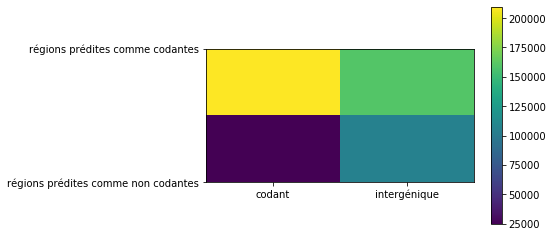

In [20]:
mat_conf2 = create_confusion_matrix(annotation_test,etats_predits2)
print(mat_conf2.shape)
plt.imshow(mat_conf2)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergénique']);
ax.set_yticklabels(['régions prédites comme codantes','régions prédites comme non codantes']);

print(mat_conf2)
plt.show()

In [38]:
TP,FP = mat_conf2[0] 
FN,TN = mat_conf2[1] 
rappel = TP/(TP+FN)*100
print(rappel)
# pas de saut conséquent

precision = TP/(TP+FP)*100
print(100-precision)
# encore moins de saut conséquent

89.47366174518416
43.270438209058625


Cette matrice ressemble à s'y méprendre à la précédente. Les valeurs numériques le confirment.  
Il ne semble donc pas que la prise en compte des codons de début et de fin soit significative (à peine +3% de détections sur les parties codantes, pas d'amélioration de la précision). En multipliant inutilement le nombre d'états, et donc le potentiel d'erreur, sans compter la durée des calculs, elle apporte une complexité inutile dont on préfère se séparer.

Petit essai d'explication (?) :  
Signaler qu'on entre dans la partie codante avec des _états_ spécifiques (comme une suite étiquetée "start") est absurde. Une chaîne de Markov prend justement en compte la succession des événements, et grâce à l'algorithme de Viterbi, on était déjà assuré.e qu'observer une succession de bases donnée impliquait d'être passé.e dans l'état codant. De fait, le codon start est _systématiquement_ présent en début de partie codante (évaluée à 1), et un codon stop est _systématiquement_ présent quand on quitte cette partie codante (évalué à 0). Le modèle avait pu l'"apprendre" à sa façon, sans qu'on le lui dise.  
Donc, le fait de détecter chaque codon start ou stop en soi est un raccourci pour un chemin qui n'en avait pas besoin, sans compter que c'est augmenter les risques de souligner de "faux" départs, comme cela a l'air d'arriver plusieurs fois (pics orange isolés sur la visualisation des résultats). 

Extras : http://mapsi.lip6.fr/pmwiki.php?n=Cours.Semaine7TME7
http://mapsi.lip6.fr/pmwiki.php?n=Cours.Semaine8TME8ADN